In [5]:
import numpy as np
import matplotlib.pyplot as plt
from simulation import inverse_kinematics_objective, draw_solutions
from idea import IDEA

In [10]:
rectangles = [((0.5, 4.), (2., 5.5))]
target_x = 1.2
target_y = 8.
S = [1.] * 15 + [0.3] * 5
d = len(S)
x_min = -np.pi
x_max = np.pi

objective = inverse_kinematics_objective(S, target_x, target_y, rectangles)
n_constraints = len(rectangles)

n = 500
n_inf = int(0.1*n)
eta_c = 5.
eta_m = 40.
p_c = 0.9
p_m = 0.2
num_iterations = 2400

populations, scores = IDEA(objective, n_constraints, x_min, x_max, d, n, n_inf, eta_c, eta_m, p_c, p_m, num_iterations, log_interval=80)

Iteration 0, #feasible: 450, #infeasible: 50, scores: [1.49259948 0.        ] [78.26833945  1.262     ] [293.92195024  24.        ]
Iteration 80, #feasible: 450, #infeasible: 50, scores: [0.00397489 0.        ] [288.46656767   3.422     ] [582.22509634  69.        ]
Iteration 160, #feasible: 450, #infeasible: 50, scores: [0.00397489 0.        ] [294.39260568   3.682     ] [591.44379727  73.        ]
Iteration 240, #feasible: 450, #infeasible: 50, scores: [0.00397489 0.        ] [299.4682368   3.918    ] [592.56524649  75.        ]
Iteration 320, #feasible: 450, #infeasible: 50, scores: [0.00267907 0.        ] [299.31818708   3.286     ] [592.65666733  75.        ]
Iteration 400, #feasible: 450, #infeasible: 50, scores: [0.00267907 0.        ] [292.6537713   3.334    ] [598.46010494  75.        ]
Iteration 480, #feasible: 450, #infeasible: 50, scores: [0.00267907 0.        ] [306.53552687   3.908     ] [600.60436796  80.        ]
Iteration 560, #feasible: 450, #infeasible: 50, scores: [

In [11]:
scores[-1, scores[-1, :, 1] == 0., 0].min()

0.00041948429279356475

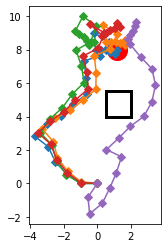

In [12]:
mask = scores[-1, :, 1] == 0.
feasible_population = populations[-1][mask, :]
best = np.argsort(scores[-1, mask, 0])[:5]
draw_solutions(feasible_population[best, :], S, target_x, target_y, rectangles)

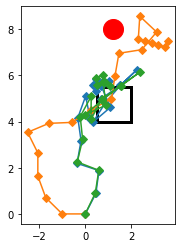

In [13]:
mask = scores[-1, :, 1] > 0.
feasible_population = populations[-1][mask, :]
best = np.argsort(scores[-1, mask, 0])[:3]
draw_solutions(feasible_population[best, :], S, target_x, target_y, rectangles)

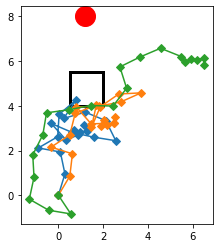

In [14]:
mask = scores[-1, :, 1] > 0.
feasible_population = populations[-1][mask, :]
best = np.argsort(scores[-1, mask, 1])[:3]
draw_solutions(feasible_population[best, :], S, target_x, target_y, rectangles)